# Define AESOPoolMarket Class

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

os.chdir('/mnt/bpet-contracts/aeso')
print(os.getcwd())

class AESOPoolMarket:
  def __init__(self):
    self.baseURL = 'http://ets.aeso.ca/ets_web/ip/Market/Reports/'

  def downloadLoop(self, reportName, beginDate, endDate):
    '''
    Loop to download report data and concatenate all together.
    Params:
    reportName: options: ['MeritOrderSnapshotEnergy', 'HistoricalPoolPrice', 'HistoricalSystemMarginalPrice']
    maxDays: MeritOrderSnapshotEnergy sets to 1; HistoricalSystemMarginalPrice sets to 31.
    beginDate: start date in string with format 'MonthDayYear'
    endDate: end date in string with format 'MonthDayYear'
    '''

    if reportName == 'MeritOrderSnapshotEnergy':
      skiprows=[0,1]
      maxDays = 1
    elif reportName == 'HistoricalSystemMarginalPrice':
      skiprows=[0,2]
      maxDays = 31
    beginDt = datetime.strptime(beginDate, '%m%d%Y')
    endDt = datetime.strptime(endDate, '%m%d%Y')
    concatList = []
    currDate = beginDt
    while currDate < endDt:
      nextDate = currDate + timedelta(days=maxDays)
      if nextDate > endDt:
        nextDate = endDt
      requestUrl = self.baseURL + '{}ReportServlet?beginDate={}&endDate={}&contentType=csv'.format(
        reportName, currDate.strftime('%m%d%Y'), nextDate.strftime('%m%d%Y')
      )
      print('requestUrl: ', requestUrl, 'skiprows: ', skiprows)
      df = pd.read_csv(requestUrl, skiprows=skiprows, engine='python')
      print('current df: ', df.describe())
      concatList.append(df)
      currDate = nextDate
    concatedDf = pd.concat(concatList)
    return concatedDf

  def downloadData(self, reportName, beginDate, endDate):
    '''
    Download historical data from AESO.
    Params:
    reportName: options: ['MeritOrderSnapshotEnergy', 'HistoricalPoolPrice', 'HistoricalSystemMarginalPrice']
    beginDate: start date in string with format 'MonthDayYear', e.g., '01012022'
    endDate: end date in string with format 'MonthDayYear', e.g., '02282022'
    '''
    requestUrl = self.baseURL + '{}ReportServlet?beginDate={}&endDate={}&contentType=csv'.format(
      reportName, beginDate, endDate
    )
    if reportName in ['MeritOrderSnapshotEnergy', 'HistoricalSystemMarginalPrice']:
      df = self.downloadLoop(reportName, beginDate, endDate)
    elif reportName == 'HistoricalPoolPrice':
      df = pd.read_csv(requestUrl, skiprows=[0,1,2,3], engine='python')
    else:
      print('Provide a valid report name!')
      return
    return df

  def calculatePoolPrice(self, prices, cumSupply, demandVolume):
    for idx in range(len(cumSupply)):
      if cumSupply[idx] >= demandVolume:
        poolPrice = prices[idx]
        poolVolume = cumSupply[idx]
        break
    return poolVolume, poolPrice

  def loadData(self, reportName, sDate, eDate):
    '''
    Load historical data from local. Only end date inclusive. If not exists, download from AESO.
    Params:
    reportName: options: ['MeritOrderSnapshotEnergy', 'HistoricalPoolPrice', 'HistoricalSystemMarginalPrice']
    beginDate: start date in string with format 'MonthDayYear', e.g., '01012022'
    endDate: end date in string with format 'MonthDayYear', e.g., '02282022'
    '''
    file = './{}_{}_{}.csv'.format(reportName, sDate, eDate)
    if os.path.exists(file):
      print('Loading {} Data {}-{} ...'.format(reportName, sDate, eDate))
      df = pd.read_csv(file, index_col=0, engine='python')
    else:
      df = self.downloadData(reportName, beginDate=sDate, endDate=eDate)
      df.to_csv(file)

    return df

  # For each hour, how is the price determined?
  def print_he_pool_price(self, date, he, supplyDf, demandDf, dispatched=False):
    df = supplyDf[(supplyDf.Date == date) & 
                  (supplyDf['Import/Export'] != 'E') & 
                  (supplyDf.HE == he)]
    if dispatched:
      df = df[df.Dispatched == 'Y']
    df_demand = demandDf[demandDf['Date (HE)'].str.contains(date)]
    prices = df.Price.unique()[::-1]
    aggSupplyAtPrice = []
    for price in prices:
      aggSupplyAtPrice.append(df[df.Price == price]['Available MW'].values.sum())
    cumSupply = np.cumsum(aggSupplyAtPrice)

    # The demand of this hour can be simulated by random numbers with the sum to be
    # the fixed total amount. Bid number sets to 100, for example, 100 retailers each
    # submits a bid only with demand amount.
    demandVolume = df_demand['AIL Demand (MW)'].values[he-1]
    demandPrice = df_demand['Price ($)'].values[he-1]

    for idx in range(len(cumSupply)):
      print(cumSupply[idx], prices[idx])
      if cumSupply[idx] >= demandVolume:
        poolPrice = prices[idx]
        poolVolume = cumSupply[idx]
        break
    print('given demand: ', demandVolume, demandPrice)

  def draw_single_date_supply_curve(self, date, supplyDf, demandDf):
    rows, cols = 6, 4
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 24))
    axs = axes.reshape(-1)
    for i in np.arange(24):
      df = supplyDf[(supplyDf.Date == date) & (supplyDf.HE == i+1) & (supplyDf['Import/Export'] != 'E')]
      prices = df.Price.unique()[::-1]
      aggSupplyAtPrice = []
      for price in prices:
        aggSupplyAtPrice.append(df[df.Price == price]['Available MW'].values.sum())
      cumSupply = np.cumsum(aggSupplyAtPrice)
      axs[i].plot(cumSupply, prices, label='supply curve')
      axs[i].set_xlabel('Energy Supply of HE={} (MWh)'.format(i+1))
      axs[i].set_ylabel('Price ($/MWh)')

      dfAtDate = demandDf[demandDf['Date (HE)'].str.contains(date)]
      poolPrice = dfAtDate['Price ($)'].values[i]
      poolVolume = dfAtDate['AIL Demand (MW)'].values[i]
      axs[i].plot(poolVolume, poolPrice, marker="o", markersize=8, 
                  markeredgecolor="black", markerfacecolor="red", label='Posted AIL & Price')
      axs[i].annotate(f"({poolVolume}, {poolPrice})",
                      (poolVolume, poolPrice),
                      textcoords="offset points",
                      xytext=(0,15),
                      ha='center')
      
      calPoolVolume, calPoolPrice = self.calculatePoolPrice(prices, cumSupply, poolVolume)
      axs[i].plot(calPoolVolume, calPoolPrice, marker="*", markersize=8, 
          markeredgecolor="black", markerfacecolor="red", label='Calculated Balance Point')
      axs[i].annotate(f"({calPoolVolume}, {calPoolPrice})",
              (calPoolVolume, calPoolPrice),
              textcoords="offset points",
              xytext=(0,-15),
              ha='center')
      axs[i].legend()
    plt.show()

/mnt/bpet-contracts/aeso


# Load Data
load Merit Order and Pool Price data
## Merit Order Columns Definitions
### General
The report shows the energy market offers available for the System Controller to dispatch based on the final state, including restatements, of the Energy Market Merit Order for each settlement interval.

For report periods prior to September 1, 2014 the report shows the energy market offers available for the System Controller to dispatch based on a snapshot of the Energy Market Merit Order taken at the 30 minute point of each settlement interval.
### Definition of Column Content
- Column 1 - Date
- Column 2 - Hour Ending
- Column 3 - Import/Export Identifier, either 'I' for Import or 'E' for Export
- Column 4 - Asset Short Name Identifier
- Column 5 - Block Number from 0 to 6
- Column 6 - Offer Price ($/MWh)
- Column 7 - Prior Block's cumulative MW
- Column 8 - Current Block's cumulative MW
- Column 9 - Block Size (MW)
- Column 10 - Available MW for the System Controller to Dispatch
- Column 11 - Dispatched MW indicator - either 'Y' or 'N'
- Column 12 - Dispatched MW
- Column 13 - Flexible block indicator - 'Y' indicates that the System Controller is able to partially dispatch the block, 'N' indicates they are not. <font color='red'>**How to determine how much to dispatch for flexible supply?**</font>
- Column 14 - Offer Control - Offer control parties separated by a semi-colon
- Column 15 - Effective Date/Time the snapshot data was taken from the Dispatch Tool (mm/dd/yyyy hh:mi)

### Timing of Updates
The report is published 60 days after the date of the snapshot and includes each hourly settlement interval for the report date.

## Pool Price Columns Definitions
- Price (\$) - Hourly Electricity Pool Price in Alberta. <font color='red'>**How to determine the price?**</font>
- 30Ravg (\$) - The 30-day Rolling Average Electricity Pool Price 
- AIL Demand (MW) - Alberta Internal Load (AIL)

In [6]:
pm = AESOPoolMarket()

In [2]:
# pd.set_option("display.max_rows", 50, "display.max_columns", None)
df_smp = pm.loadData('HistoricalSystemMarginalPrice', '01012022', '02282022')
smp = df_smp[df_smp['Date (HE)'] == '01/01/2022 01']['Price ($)'].values
print(smp, np.round(smp.mean(), 2), 'Weighted average should result in $65.64')
df_smp

Loading HistoricalSystemMarginalPrice Data 01012022-02282022 ...
[62.83 65.02 69.07 70.25 69.07 65.02 62.83] 66.3 Weighted average should result in $65.64


,Date (HE),Time,Price ($)
0,01/31/2022 24,23:00,68.26
1,01/31/2022 23,22:43,67.66
2,01/31/2022 23,22:21,70.15
3,01/31/2022 23,22:00,70.60
4,01/31/2022 22,21:47,70.60
...,...,...,...
2596,02/01/2022 02,01:00,69.89
2597,02/01/2022 01,24:23,69.77
2598,02/01/2022 01,24:16,69.89
2599,02/01/2022 01,24:14,72.55


In [3]:
df_mo = pm.loadData('MeritOrderSnapshotEnergy', '01012022', '02282022')
df_mo

Loading MeritOrderSnapshotEnergy Data 01012022-02282022 ...


,Date,HE,Import/Export,Asset Id,Block Number,Price,From,To,Size,Available MW,Dispatched,Dispatched MW,Flexible,Offer Control,Effective Date/Time
0,01/01/2022,1,NaN,ME04,1,999.99,4,6,2,0,N,0,Y,URICA Asset Optimization Ltd.,01/01/2022 00:58
1,01/01/2022,1,NaN,BHL1,1,999.99,3,5,2,2,N,0,Y,URICA Asset Optimization Ltd.,01/01/2022 00:58
2,01/01/2022,1,NaN,COD1,1,999.99,3,5,2,2,N,0,Y,Signalta Resources Limited,01/01/2022 00:58
3,01/01/2022,1,NaN,BFD1,1,999.99,3,6,3,3,N,0,N,Horseshoe Power GP Ltd.,01/01/2022 00:58
4,01/01/2022,1,NaN,ALP1,1,999.99,4,7,3,3,N,0,Y,Campus Energy Partners LP,01/01/2022 00:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5388,02/28/2022,24,NaN,GN2,0,0.00,0,300,300,300,Y,300,N,Capital Power GP Holdings Inc.,02/28/2022 23:52
5389,02/28/2022,24,NaN,EGC1,0,0.00,0,390,390,390,Y,390,N,Capital Power GP Holdings Inc.; ENMAX Energy C...,02/28/2022 23:52
5390,02/28/2022,24,NaN,KH3,0,0.00,0,463,463,463,Y,463,Y,TransAlta Energy Marketing Corp.,02/28/2022 23:52
5391,02/28/2022,24,NaN,SCR6,0,0.00,0,465,465,465,Y,465,Y,Suncor Energy Inc.,02/28/2022 23:52


In [56]:
df_pp = pm.loadData('HistoricalPoolPrice', '01012022', '02282022')
df_pp

Loading HistoricalPoolPrice Data 01012022-02282022 ...


,Date (HE),Price ($),30Ravg ($),AIL Demand (MW)
0,01/01/2022 01,65.64,127.10,10746.0
1,01/01/2022 02,61.59,127.10,10618.0
2,01/01/2022 03,56.67,127.11,10499.0
3,01/01/2022 04,45.58,127.12,10451.0
4,01/01/2022 05,57.39,127.12,10408.0
...,...,...,...,...
1387,02/27/2022 20,69.21,101.38,10931.0
1388,02/27/2022 21,67.11,101.40,10841.0
1389,02/27/2022 22,63.30,101.42,10626.0
1390,02/27/2022 23,53.88,101.43,10311.0


In [33]:
pm.loadData('HistoricalPoolPrice', '03012022', '12302022')

,Date (HE),Price ($),30Ravg ($),AIL Demand (MW)
0,03/01/2022 01,73.07,101.79,9784.0
1,03/01/2022 02,72.85,101.82,9683.0
2,03/01/2022 03,72.56,101.86,9681.0
3,03/01/2022 04,72.32,101.89,9691.0
4,03/01/2022 05,72.80,101.93,9757.0
...,...,...,...,...
7291,12/29/2022 20,88.73,329.65,11020.0
7292,12/29/2022 21,88.88,328.63,10886.0
7293,12/29/2022 22,89.07,327.62,10705.0
7294,12/29/2022 23,87.09,327.25,10461.0


# Plot Daily Supply Curve

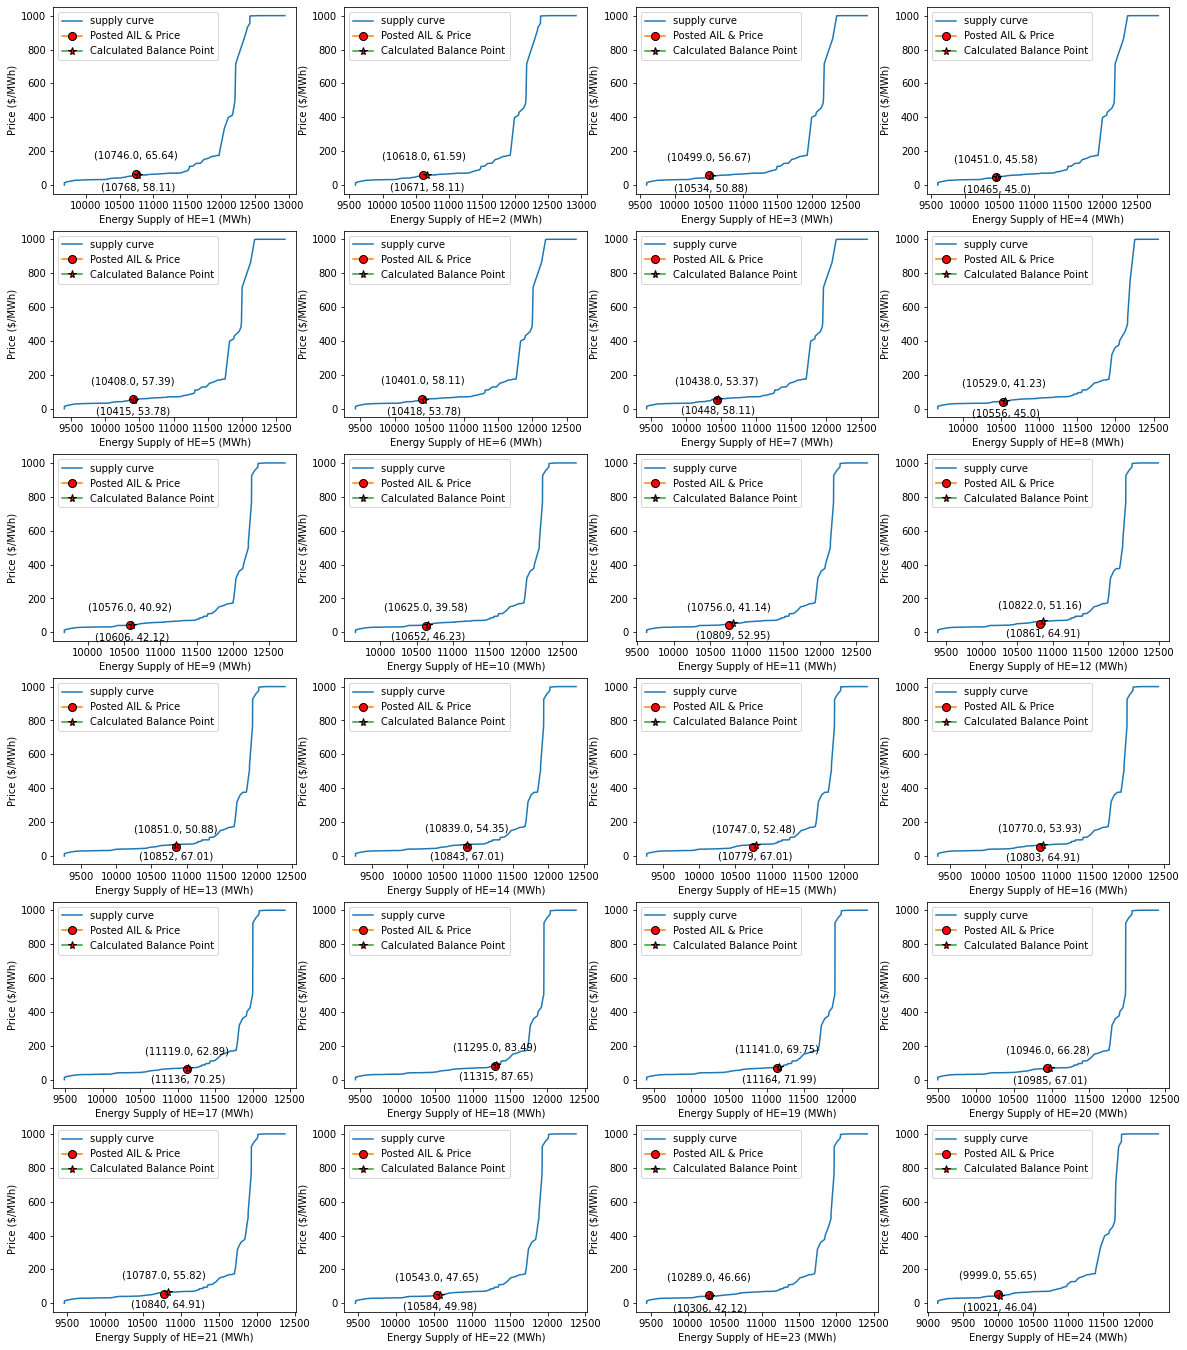

In [57]:
pm.draw_single_date_supply_curve(date='01/01/2022',supplyDf=df_mo, demandDf=df_pp)

In [34]:
df_smp

,Unnamed: 0,Date (HE),Time,Price ($)
15623,287,03/02/2022 18,17:29,325.27
15624,288,03/02/2022 18,17:23,300.00
15625,289,03/02/2022 18,17:18,289.31
15626,290,03/02/2022 18,17:00,278.22


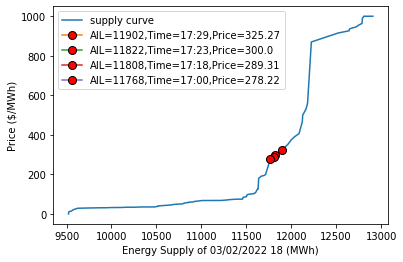

In [40]:
date = '03/02/2022'
he = 18
datehe = date +' '+str(he)
df = pd.read_csv("MeritOrderSnapshotEnergy_03012022_05012022.csv")
df_moe = df[(df['Date'] == date) & ((df['HE'] == he))]

df_smp = pd.read_csv("HistoricalSystemMarginalPrice_09012021_08312022.csv")
df_smp = df_smp[df_smp['Date (HE)'] == datehe]
df_smp

fig, ax = plt.subplots()

df = df_moe[df_moe['Import/Export'] != 'E']
# sort unique prices in an ascending order
prices = df.Price.unique()[::-1]
aggSupplyAtPrice = []
for price in prices:
  aggSupplyAtPrice.append(df[df.Price == price]['Available MW'].values.sum())
cumSupply = np.cumsum(aggSupplyAtPrice)
ax.plot(cumSupply, prices, label='supply curve')
ax.set_xlabel('Energy Supply of {} (MWh)'.format(datehe))
ax.set_ylabel('Price ($/MWh)')

for _, item in df_smp.iterrows():
  smp = item['Price ($)']
  time = item['Time']
  idx = np.where(prices == smp)
  poolVolume = cumSupply[idx][0]

  ax.plot(poolVolume, smp, marker="o", markersize=8, 
              markeredgecolor="black", markerfacecolor="red", label='AIL={},Time={},Price={}'.format(poolVolume, time, smp))
  ax.legend()

plt.show()
fig.savefig('demand_supply_curve_03022022_18.png',dpi=300)

# Collect SMP Dataset

In [89]:
baseURL = 'http://ets.aeso.ca/ets_web/ip/Market/Reports/'
requestUrl = baseURL + '{}ReportServlet?beginDate={}&endDate={}&contentType=csv'.format(
  'HistoricalSystemMarginalPrice', '07242022', '07252022'
)
df_smp = pd.read_csv(requestUrl, skiprows=[0,2], engine='python')
print(df_smp.head())
df_smp[['Date', 'HE']] = df_smp['Date (HE)'].str.split(' ', expand=True)
df_smp['Time'] = df_smp['Time'].str.replace('24:', '00:')
df_smp['Datetime'] = df_smp['Date'] + df_smp['Time']
df_smp['Datetime'] = df_smp['Datetime'].str.replace('2022', '2022 ')
df_smp['Datetime'] = pd.to_datetime(df_smp['Datetime'], format='%m/%d/%Y %H:%M')
df_smp['tDatetime'] = df_smp['Datetime']
df_smp['delta'] = ((df_smp['tDatetime'].shift() - df_smp['tDatetime']) / np.timedelta64(1, 'm')).fillna(0)
df_smp.at[0, 'delta'] = (df_smp.iloc[0].Datetime.round(freq='H') - df_smp.iloc[0].Datetime) / np.timedelta64(1, 'm')
df_smp['HE'] = df_smp['HE'].astype(int)
df_smp.head()

       Date (HE)   Time  Price ($)
0  07/24/2022 24  23:54      69.01
1  07/24/2022 24  23:47      70.56
2  07/24/2022 24  23:42      72.07
3  07/24/2022 24  23:36      75.64
4  07/24/2022 24  23:27      80.04


,Date (HE),Time,Price ($),Date,HE,Datetime,tDatetime,delta
0,07/24/2022 24,23:54,69.01,07/24/2022,24,2022-07-24 23:54:00,2022-07-24 23:54:00,6.0
1,07/24/2022 24,23:47,70.56,07/24/2022,24,2022-07-24 23:47:00,2022-07-24 23:47:00,7.0
2,07/24/2022 24,23:42,72.07,07/24/2022,24,2022-07-24 23:42:00,2022-07-24 23:42:00,5.0
3,07/24/2022 24,23:36,75.64,07/24/2022,24,2022-07-24 23:36:00,2022-07-24 23:36:00,6.0
4,07/24/2022 24,23:27,80.04,07/24/2022,24,2022-07-24 23:27:00,2022-07-24 23:27:00,9.0


In [91]:
list_pp = []
for he in range(1,25):
  # take the weighted mean value of all MSP in an hour
  df = df_smp[(df_smp.Date == '07/24/2022') & (df_smp.HE == he)]
  currTotalPrice = 0
  for _, item in df.iterrows():
    currTotalPrice += float(item['Price ($)']) * float(item['delta'])
  list_pp.append(np.round(currTotalPrice/60, 2))
print(list_pp)

[68.51, 64.5, 52.85, 45.57, 40.5, 39.15, 40.63, 34.55, 45.02, 61.34, 79.69, 83.03, 85.29, 83.69, 86.72, 90.05, 201.95, 390.64, 243.73, 245.14, 181.67, 106.98, 82.56, 77.45]


In [92]:
pm = AESOPoolMarket()
df_pp_220724 = pm.loadData('HistoricalPoolPrice', '07242022', '07252022')
df_pp_220724.head()

Loading HistoricalPoolPrice Data 07242022-07252022 ...


,Date (HE),Price ($),30Ravg ($),AIL Demand (MW)
0,07/24/2022 01,68.51,111.72,9375.0
1,07/24/2022 02,64.50,111.74,9178.0
2,07/24/2022 03,52.85,111.74,9037.0
3,07/24/2022 04,45.57,111.72,8915.0
4,07/24/2022 05,40.50,111.70,8741.0


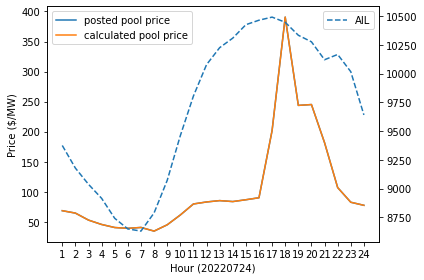

In [93]:
posted_pp = df_pp_220724['Price ($)'].values
posted_ail = df_pp_220724['AIL Demand (MW)'].values
fig, ax = plt.subplots()
X = np.arange(1,len(posted_pp)+1)
ax.plot(X, posted_pp, label='posted pool price')
ax.plot(X, list_pp, label='calculated pool price')
ax.set_xticks(X)
ax.set_xlabel('Hour (20220724)')
ax.set_ylabel('Price ($/MW)')
ax.legend()
ax2 = ax.twinx()
ax2.plot(X, posted_ail, label='AIL', linestyle='--')
ax2.legend()
plt.tight_layout()
plt.show()


In [8]:
df = pd.read_csv('MeritOrderSnapshotEnergy_01012022_02282022.csv', index_col=0)
df = df[df['Date'] == '01/01/2022']
for he in range(1,25):
  df_he = df[df['HE'] == he]
  print(len(df_he['Asset Id'].values), len(df_he['Asset Id'].unique()))

230 128
230 127
223 124
224 124
225 125
225 125
223 123
224 126
230 129
231 129
230 129
232 129
232 128
232 128
232 126
233 127
235 129
236 130
235 129
235 129
235 130
233 129
232 129
229 126


In [9]:
# pd.set_option('display.max_rows', None)
df[df['Date'] == '01/01/2022'].sort_values(['Asset Id', 'HE']).head(20)

,Date,HE,Import/Export,Asset Id,Block Number,Price,From,To,Size,Available MW,Dispatched,Dispatched MW,Flexible,Offer Control,Effective Date/Time
38,01/01/2022,1,NaN,AFG1,3,500.0,26,32,6,6,N,0,N,Alberta Pacific Forest Industries,01/01/2022 00:58
45,01/01/2022,1,NaN,AFG1,2,200.0,18,26,8,8,N,0,N,Alberta Pacific Forest Industries,01/01/2022 00:58
66,01/01/2022,1,NaN,AFG1,1,80.0,13,18,5,5,N,0,N,Alberta Pacific Forest Industries,01/01/2022 00:58
133,01/01/2022,1,NaN,AFG1,0,0.0,0,13,13,13,Y,13,N,Alberta Pacific Forest Industries,01/01/2022 00:58
268,01/01/2022,2,NaN,AFG1,3,500.0,26,32,6,6,N,0,N,Alberta Pacific Forest Industries,01/01/2022 01:58
275,01/01/2022,2,NaN,AFG1,2,200.0,18,26,8,8,N,0,N,Alberta Pacific Forest Industries,01/01/2022 01:58
297,01/01/2022,2,NaN,AFG1,1,80.0,13,18,5,5,N,0,N,Alberta Pacific Forest Industries,01/01/2022 01:58
363,01/01/2022,2,NaN,AFG1,0,0.0,0,13,13,13,Y,13,N,Alberta Pacific Forest Industries,01/01/2022 01:58
491,01/01/2022,3,NaN,AFG1,3,500.0,26,32,6,6,N,0,N,Alberta Pacific Forest Industries,01/01/2022 02:56
498,01/01/2022,3,NaN,AFG1,2,200.0,18,26,8,8,N,0,N,Alberta Pacific Forest Industries,01/01/2022 02:56


# Merit Order Effect Example

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
df_meo = pd.read_csv('../sampledata.csv')
df_meo

,No.,User Type,Price($/MWh),Amount(MWh)
0,1,Supplier,20,500
1,2,Supplier,40,600
2,3,Supplier,70,700
3,4,Supplier,80,1700
4,5,Supplier,90,1000
5,6,Consumer,20,800
6,7,Consumer,40,900
7,8,Consumer,70,800
8,9,Consumer,90,500
9,10,Consumer,100,500


In [4]:
df_meo.iloc[::-1]

,No.,User Type,Price($/MWh),Amount(MWh)
9,10,Consumer,100,500
8,9,Consumer,90,500
7,8,Consumer,70,800
6,7,Consumer,40,900
5,6,Consumer,20,800
4,5,Supplier,90,1000
3,4,Supplier,80,1700
2,3,Supplier,70,700
1,2,Supplier,40,600
0,1,Supplier,20,500


In [5]:
supply_price = df_meo[df_meo['User Type'] == 'Supplier']['Price($/MWh)'].values
consumer_price = df_meo[::-1][df_meo[::-1]['User Type'] == 'Consumer']['Price($/MWh)'].values

supply_cumsum = np.cumsum(df_meo[df_meo['User Type'] == 'Supplier']['Amount(MWh)'].values)
consumer_cumsum = np.cumsum(df_meo[::-1][df_meo[::-1]['User Type'] == 'Consumer']['Amount(MWh)'].values)

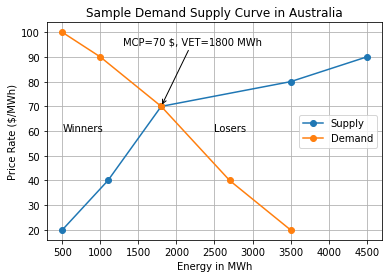

In [6]:
fig, ax = plt.subplots()
ax.plot(supply_cumsum, supply_price, marker='o', label='Supply')
ax.plot(consumer_cumsum, consumer_price, marker='o', color='tab:orange',label='Demand')
ax.grid()
ax.set_title('Sample Demand Supply Curve in Australia')
ax.annotate("MCP=70 $, VET=1800 MWh",
            xy=(1800, 70), xycoords='data',
            xytext=(1300, 95), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
ax.text(x=500, y=60, s='Winners')
ax.text(x=2500, y=60, s='Losers')
ax.legend(loc='right')
ax.set_xlabel('Energy in MWh')
ax.set_ylabel('Price Rate ($/MWh)')
plt.show()
fig.savefig('Australia_moe.pdf')
fig.savefig('Australia_moe.png',dpi=300)

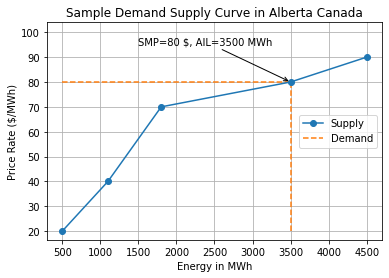

In [6]:
fig, ax = plt.subplots()
ax.plot(supply_cumsum, supply_price, marker='o', label='Supply')
ax.hlines(y=[80], xmin=500, xmax=3500, color='tab:orange', linestyle='--', label='Demand')
ax.vlines(x=[3500], ymin=20, ymax=80, color='tab:orange',  linestyle='--')
ax.set_title('Sample Demand Supply Curve in Alberta Canada')
ax.annotate("SMP=80 $, AIL=3500 MWh",
            xy=(3500, 80), xycoords='data',
            xytext=(1500, 95), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
ax.set_xlabel('Energy in MWh')
ax.set_ylabel('Price Rate ($/MWh)')
ax.set_ylim(top=104)
ax.grid()
ax.legend(loc='right')
plt.show()
fig.savefig('Alberta_moe.pdf')
fig.savefig('Alberta_moe.png',dpi=300)

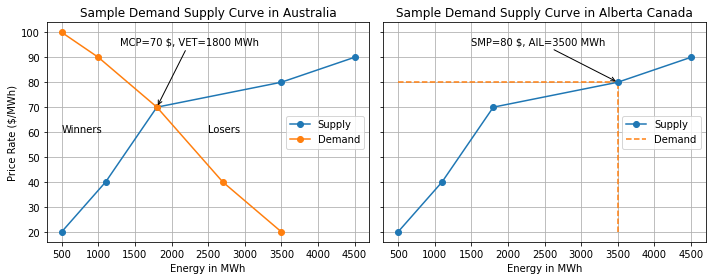

In [19]:
# Combine figs
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))
axes[0].plot(supply_cumsum, supply_price, marker='o', label='Supply')
axes[0].plot(consumer_cumsum, consumer_price, marker='o', color='tab:orange',label='Demand')
axes[0].grid()
axes[0].set_title('Sample Demand Supply Curve in Australia')
axes[0].annotate("MCP=70 $, VET=1800 MWh",
            xy=(1800, 70), xycoords='data',
            xytext=(1300, 95), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
axes[0].text(x=500, y=60, s='Winners')
axes[0].text(x=2500, y=60, s='Losers')
axes[0].legend(loc='right')
axes[0].set_xlabel('Energy in MWh')
axes[0].set_ylabel('Price Rate ($/MWh)')
# plt.show()
# fig.savefig('Australia_moe.pdf')
# fig.savefig('Australia_moe.png',dpi=300)


# fig, ax = plt.subplots()
axes[1].plot(supply_cumsum, supply_price, marker='o', label='Supply')
axes[1].hlines(y=[80], xmin=500, xmax=3500, color='tab:orange', linestyle='--', label='Demand')
axes[1].vlines(x=[3500], ymin=20, ymax=80, color='tab:orange',  linestyle='--')
axes[1].set_title('Sample Demand Supply Curve in Alberta Canada')
axes[1].annotate("SMP=80 $, AIL=3500 MWh",
            xy=(3500, 80), xycoords='data',
            xytext=(1500, 95), textcoords='data',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            )
axes[1].set_xlabel('Energy in MWh')
# axes[1].set_ylabel('Price Rate ($/MWh)')
axes[1].set_ylim(top=104)
axes[1].grid()
axes[1].legend(loc='right')
plt.tight_layout()
plt.show()

fig.savefig('moe.pdf')
fig.savefig('moe.png',dpi=300)

# BPET Case Study

## Load Data

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import progressbar as pb
import math
os.chdir('/mnt/bpet-contracts/aeso')
print(os.getcwd())

def download_data(reportName: str, beginDate: str, endDate: str) -> pd.DataFrame:
  baseURL = 'http://ets.aeso.ca/ets_web/ip/Market/Reports/'
  skiprows=[0,1]
  maxDays = 1
  beginDt = datetime.strptime(beginDate, '%m%d%Y')
  endDt = datetime.strptime(endDate, '%m%d%Y')
  if reportName == 'HistoricalSystemMarginalPrice':
    skiprows=[0,2]
    maxDays = 31

  concatList = []
  currDate = beginDt
  total_downloads = math.ceil((endDt - beginDt).days / maxDays)
  bar = pb.ProgressBar(maxval=total_downloads, \
    widgets=[pb.Bar('=', '[', ']'), ' ', pb.Percentage()])
  bar.start()
  i = 0
  while currDate < endDt:
    nextDate = currDate + timedelta(days=maxDays)
    if nextDate > endDt:
      nextDate = endDt
    requestUrl = baseURL + '{}ReportServlet?beginDate={}&endDate={}&contentType=csv'.format(
      reportName, currDate.strftime('%m%d%Y'), nextDate.strftime('%m%d%Y')
    )
    i += 1
    bar.update(i)
    df = pd.read_csv(requestUrl, skiprows=skiprows, engine='python')
    concatList.append(df)
    currDate = nextDate
  bar.finish()
  concatedDf = pd.concat(concatList)
  file = './{}_{}_{}.csv'.format(reportName, beginDate, endDate)
  concatedDf.to_csv(file)
  return concatedDf

def calculate_offer_updates(start_date: str, end_date: str) -> pd.DataFrame:

  file = './{}_{}_{}.csv'.format('MeritOrderSnapshotEnergy', start_date, end_date)
  df = pd.read_csv(file, index_col='Unnamed: 0').reset_index(drop=True)
  dates = df.Date.unique()
  offer_submission_freq = []
  hours = df.HE.unique()

  # for each hour, check if each entry exists in the previous hour
  # including 'Asset Id', 'Block Number',	'Price',	'From',	'To',	'Size',	'Available MW'
  # if not exist, this is an updated or new offer

  for d in range(1, len(dates)):
    df00 = df[df.Date == dates[d - 1]]
    df01 = df[df.Date == dates[d]]
    update_idx = []
    df_last_hour = df00[df00.HE == hours[-1]]
    for i in range(len(hours)):
      df_current_hour = df01[df01.HE == hours[i]]
      current_update_num = 0
      for idx, row in df_current_hour.iterrows():
        if not ((df_last_hour['Asset Id'] == row['Asset Id']) &
            (df_last_hour['Block Number'] == row['Block Number']) &
            (df_last_hour['Price'] == row['Price']) &
            (df_last_hour['From'] == row['From']) &
            (df_last_hour['To'] == row['To']) &
            (df_last_hour['Size'] == row['Size']) &
            (df_last_hour['Available MW'] == row['Available MW'])
          ).any():
          current_update_num += 1
      if current_update_num > 0:
        update_idx.append(current_update_num)
      df_last_hour = df_current_hour
    offer_submission_freq.append(update_idx)

  filename = 'MeritOrderUpdates_{}_{}.csv'.format(start_date, end_date)
  df_updates = pd.DataFrame.from_records(offer_submission_freq).dropna(axis=1)
  df_updates['Date'] = dates[1:]
  df_updates = df_updates.set_index(keys=['Date'])
  df_updates.to_csv(filename)
  print(df_updates.head())
  print(df_updates.index.size)
  print(df_updates.columns.size)
  return df_updates

def plot_updates(df_updates):
  index = df_updates.index
  entry_num = df_updates.index.size
  ncols = 4
  nrows = math.ceil(entry_num / ncols)
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows))
  axes = axs.flatten()
  for i in range(entry_num):
    data = df_updates.loc[df_updates.index == index[i]].iloc[0].values
    axes[i].plot(data)
    axes[i].set_title(index[i])
  plt.tight_layout()
  plt.show()

/mnt/bpet-contracts/aeso


### Offer Updates 030122-050122

            0   1   2   3   4   5   6   7   8   9   ...  13  14  15  16  17  \
Date                                                ...                       
03/02/2022  93  17  19  29  26  37  39  79  31  28  ...  39  28  28  17  33   
03/03/2022  87  16  22  22  22  29  36  90  38  25  ...  30  32  30  24  34   
03/04/2022  89  21  27  25  26  21  26  92  31  23  ...  23  37  29  22  30   
03/05/2022  90  23  25  28  25  15  27  88  34  30  ...  31  48  28  20  34   
03/06/2022  62  16  11   9  21  14  16  74  31  27  ...  35  31  26  23  25   

            18  19  20  21  22  
Date                            
03/02/2022  26  28  40  28  42  
03/03/2022  30  36  33  28  36  
03/04/2022  33  34  28  27  32  
03/05/2022  26  33  36  24  26  
03/06/2022  33  33  37  26  22  

[5 rows x 23 columns]
60
23


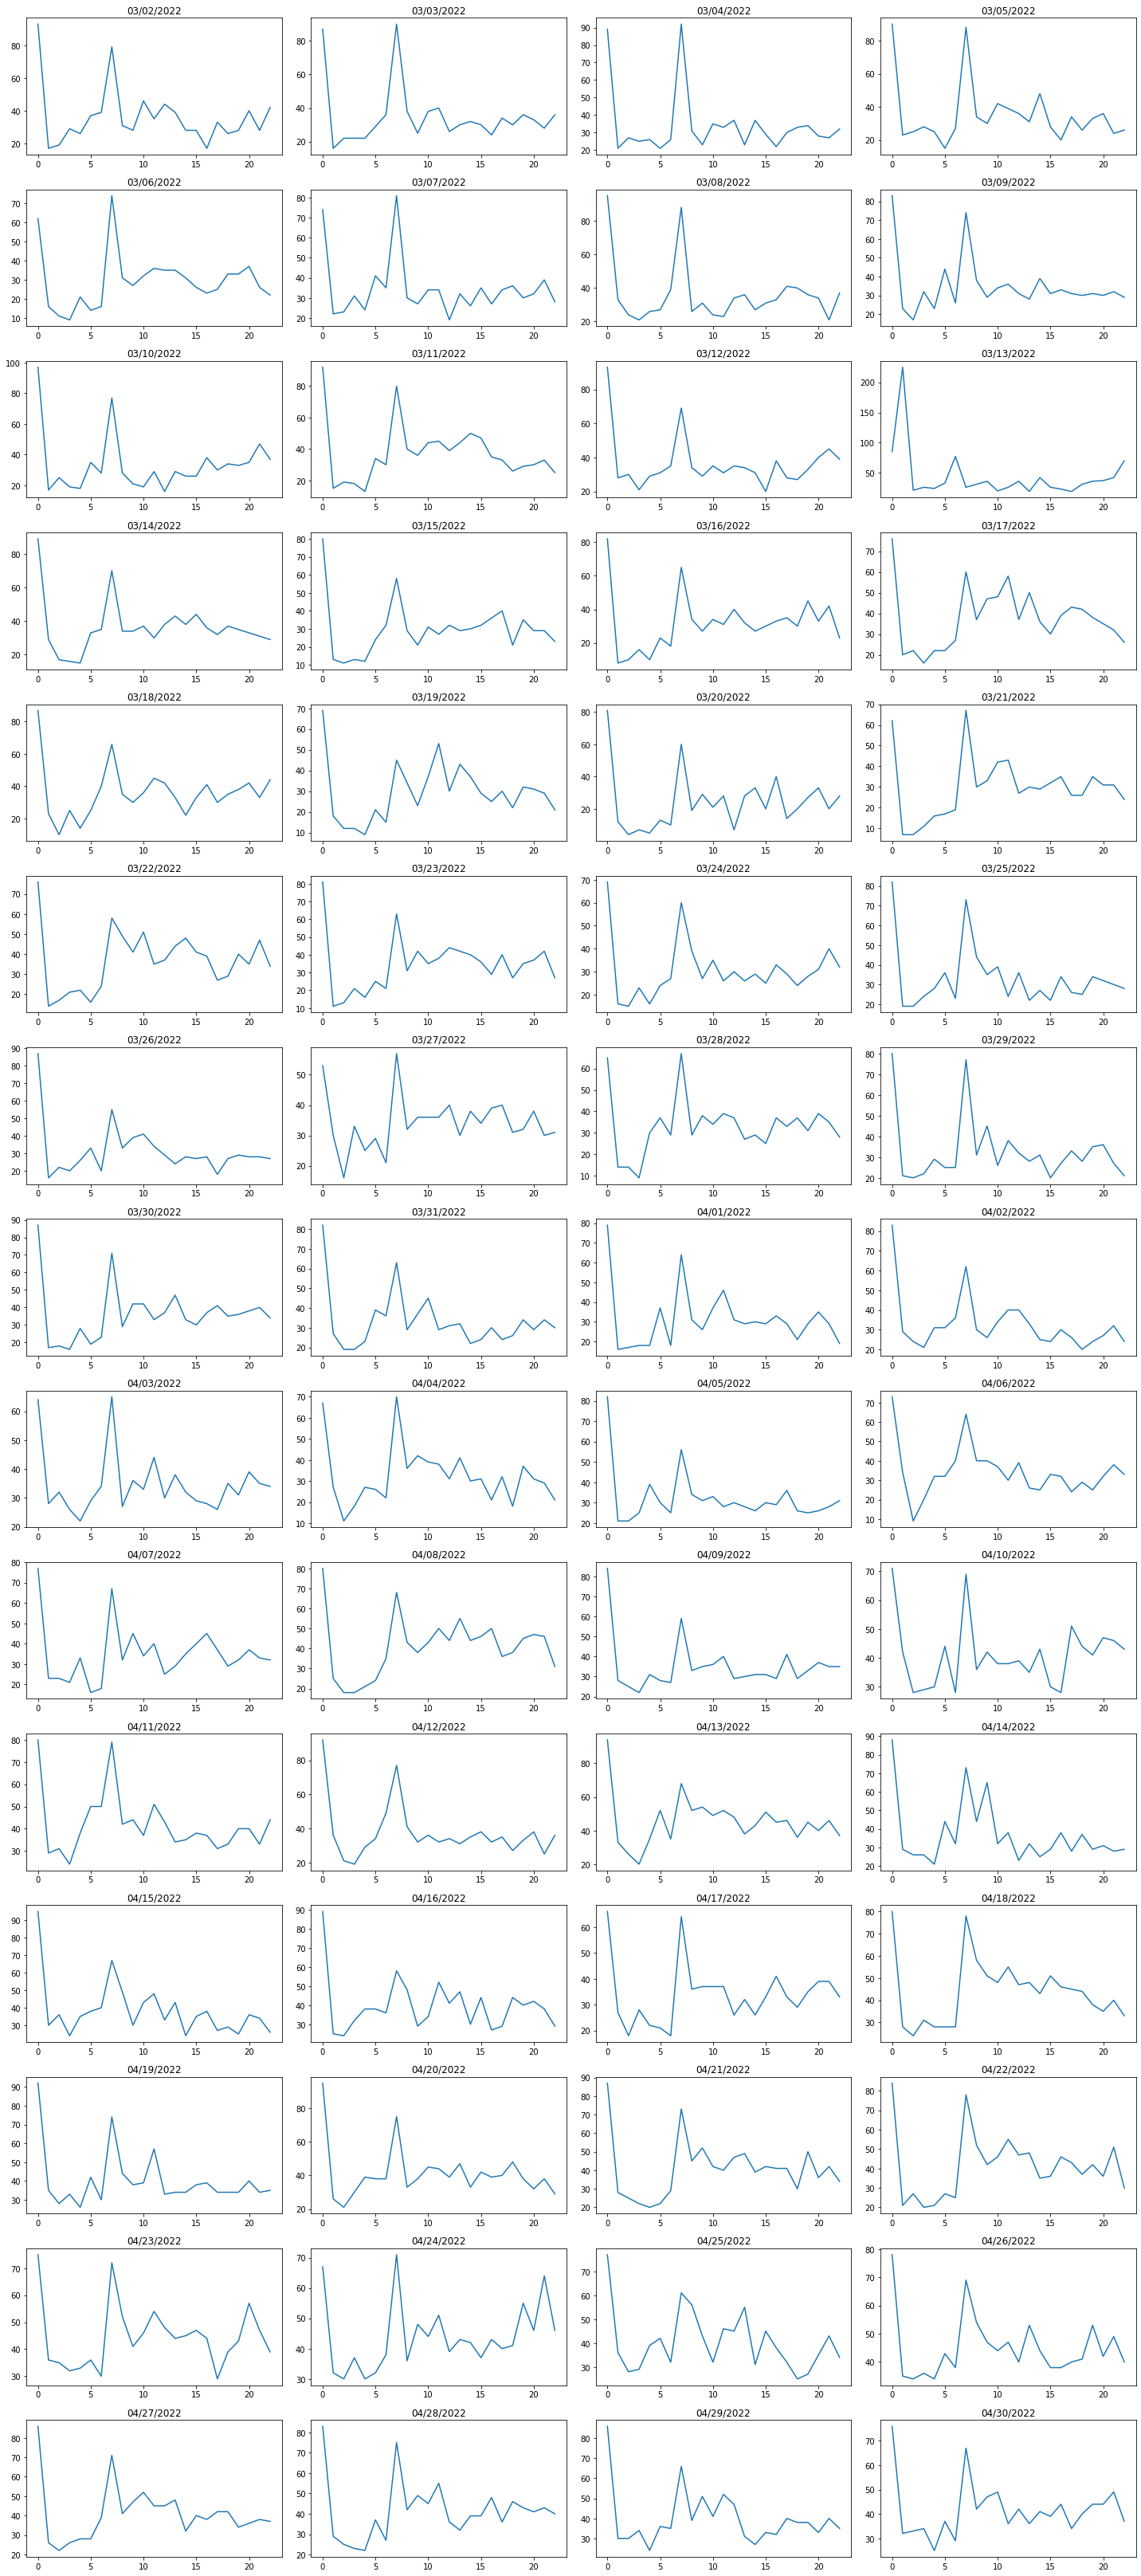

In [12]:
df_updates = calculate_offer_updates(start_date='03012022', end_date='05012022')
plot_updates(df_updates)

## Analyze the real supply & demand

1. Analyze how often the supply changes => submit offer TPS?
   - Dataset: merit order data from 2021-09-01 to 2022-08-31
   - Each day, what are the offer change rates from HE to HE? 5% updated offers each hour HE?
2. Analyze how often the demand changes => submit bid TPS?

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

filenames = os.listdir()
update_filenames = [file for file in filenames if 'MeritOrderUpdates' in file]

df_list = []
for file in update_filenames:
  df = pd.read_csv(file)
  df_list.append(df)
df = pd.concat(df_list)
df.to_csv('mou_whole_year.csv')
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df.describe().round(decimals=0).to_csv('stats.csv')

In [12]:
df

,Date,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,05/02/2022,69,49,49,36,35,43,36,67,53,...,40,47,54,42,30,38,36,50,46,80.0
1,05/03/2022,86,39,28,30,28,27,35,80,49,...,37,39,47,44,33,32,31,43,30,68.0
2,05/04/2022,73,24,21,26,22,25,26,58,35,...,28,29,30,30,34,32,41,40,25,55.0
3,05/05/2022,71,27,26,29,20,27,28,65,38,...,29,33,33,37,25,35,32,41,27,62.0
4,05/06/2022,76,44,23,29,29,29,29,72,38,...,22,36,37,39,47,27,38,42,34,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,10/26/2021,101,24,13,18,21,24,35,74,32,...,37,26,24,42,40,27,34,41,24,60.0
55,10/27/2021,88,20,15,22,19,26,23,78,36,...,40,34,30,37,31,28,21,39,12,49.0
56,10/28/2021,76,22,8,20,12,18,29,76,29,...,33,25,47,35,34,33,31,28,30,63.0
57,10/29/2021,103,21,33,22,30,29,46,77,44,...,25,28,35,29,25,40,27,35,32,68.0


In [23]:

df.describe().round(decimals=0)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
count,356,356,356,356,356,356,356,356,356,356,...,356,356,356,356,356,356,356,356,356,296
mean,106,29,26,27,26,33,31,73,43,41,...,36,35,37,35,34,37,38,39,37,68
std,53,15,10,14,10,10,10,13,12,13,...,11,11,10,9,9,10,10,15,14,12
min,52,3,1,4,5,7,10,26,19,10,...,10,7,16,14,11,10,11,15,9,28
25%,76,21,19,19,19,26,24,65,33,30,...,29,27,30,29,28,31,31,31,27,60
50%,87,27,25,25,25,33,30,72,41,39,...,35,33,36,35,33,35,36,38,34,68
75%,98,35,33,32,32,39,36,80,51,48,...,42,40,43,40,39,42,42,45,44,75
max,245,225,60,216,69,62,77,110,82,87,...,75,85,73,69,64,72,73,216,82,104


In [21]:
# get supply data
mo_files = [file for file in os.listdir() if 'MeritOrderSnapshot' in file]
df_list = []
for file in mo_files:
  df = pd.read_csv(file, index_col='Unnamed: 0')
  # assets_list = df['Asset Id'].unique()
  # print('Assets number of {} is: {}'.format(file, len(assets_list)))
  df_list.append(df)
df = pd.concat(df_list)
assets = df['Asset Id'].unique()
print(len(assets))
assets

/tmp/ipykernel_952378/3637338040.py:5: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, index_col='Unnamed: 0')


201


array(['COD1', 'BHL1', 'ME04', 'ICP1', 'ALP1', 'BFD1', 'ME03', 'WCD1',
       'NAT1', 'ME02', 'SDH1', 'ALP2', 'SCR6', 'CRS3', 'WWD1', 'AFG1',
       'CRS2', 'ENC2', 'BRA', 'ENC3', 'CRS1', 'ENC1', 'CMH1', 'SUM1',
       'SH1', 'BOW1', 'EC01', 'EGC1', 'SD6', 'SET1', 'VVW1', 'BIG',
       'ALS1', 'NPP1', 'DAI1', 'SH2', 'GEN6', 'GN1', 'DOWG', 'VVW2',
       'PH1', 'ANC1', 'KH3', 'HRT1', 'SCR5', 'EAGL', 'HRM', 'FH1', 'JOF1',
       'NX01', 'TC01', 'GN2', 'WEF1', 'BUR1', 'DRW1', 'DKSN', 'MUL1',
       'CHIN', 'WST1', 'BRD1', 'TLM2', 'GPEC', 'UOC1', 'TAY1', 'BRK1',
       'BUL1', 'BRK2', 'RYMD', 'CRE3', 'BSC1', 'BUL2', 'OMRH', 'STR1',
       'INF1', 'ERV2', 'ERV1', 'VXH1', 'HYS1', 'STR2', 'SUF1', 'JER1',
       'SCL1', 'HUL1', 'TVS1', 'CRR2', 'SCR2', 'SCR3', 'CR1', 'FNG1',
       'WEY1', 'SCR1', 'OWF1', 'RL1', 'MOMT', 'RB5', 'MEG1', 'BCRK',
       'CLR1', 'BTR1', 'IEW1', 'ARD1', 'KHW1', 'IEW2', 'GWW1', 'AKE1',
       'IOR1', 'EC04', 'CLR2', 'CRR1', 'TAB1', 'PR1', 'NEP1', 'TC02',
       'SCR4'

- Assets number of MeritOrderSnapshotEnergy_05012022_08312022.csv is: 171
- Assets number of MeritOrderSnapshotEnergy_11012021_12302021.csv is: 157
- Assets number of MeritOrderSnapshotEnergy_09012021_10312021.csv is: 165
- Assets number of MeritOrderSnapshotEnergy_01012022_02282022.csv is: 154
- Assets number of MeritOrderSnapshotEnergy_03012022_05012022.csv is: 163

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314909 entries, 0 to 5392
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Date                 314909 non-null  object 
 1   HE                   314909 non-null  int64  
 2   Import/Export        4478 non-null    object 
 3   Asset Id             314909 non-null  object 
 4   Block Number         314909 non-null  int64  
 5   Price                314909 non-null  float64
 6   From                 314909 non-null  int64  
 7   To                   314909 non-null  int64  
 8   Size                 314909 non-null  int64  
 9   Available MW         314909 non-null  int64  
 10  Dispatched           314909 non-null  object 
 11  Dispatched MW        314909 non-null  int64  
 12  Flexible             314909 non-null  object 
 13  Offer Control        314909 non-null  object 
 14  Effective Date/Time  314909 non-null  object 
dtypes: float64(1), int6

In [29]:
df[['Asset Id', 'Block Number', 'Price', 'Available MW']].value_counts()

Asset Id  Block Number  Price   Available MW
INF1      0             0.00    19              1416
TLM2      0             0.00    13              1416
CLR1      0             0.00    58              1416
BSC1      0             0.00    15              1416
CLR2      0             0.00    75              1416
                                                ... 
KH3       1             245.61  75                 1
                        254.16  75                 1
                        279.87  75                 1
                        289.89  75                 1
KH2       1             58.10   55                 1
Length: 21092, dtype: int64

In [4]:
# get demand data

# BPET Simulation

In [13]:
df = pd.read_csv('HistoricalPoolPrice_03012022_12302022.csv', index_col=0)
dt = []
for oldtime in df['Date (HE)'].values:
  frag = oldtime.split(' ')
  newtime = frag[0] + ' ' + str(int(frag[1]) - 1)
  dt.append(newtime)
df['DateTime'] = dt
df[['Date', 'HE']] = df['Date (HE)'].str.split(' ', expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DateTime'] = pd.to_datetime(df['DateTime'], format='%m/%d/%Y %H')
df.set_index('DateTime', inplace=True)
df

,Date (HE),Price ($),30Ravg ($),AIL Demand (MW),Date,HE
DateTime,,,,,,
2022-03-01 00:00:00,03/01/2022 01,73.07,101.79,9784.0,2022-03-01,01
2022-03-01 01:00:00,03/01/2022 02,72.85,101.82,9683.0,2022-03-01,02
2022-03-01 02:00:00,03/01/2022 03,72.56,101.86,9681.0,2022-03-01,03
2022-03-01 03:00:00,03/01/2022 04,72.32,101.89,9691.0,2022-03-01,04
2022-03-01 04:00:00,03/01/2022 05,72.80,101.93,9757.0,2022-03-01,05
...,...,...,...,...,...,...
2022-12-29 19:00:00,12/29/2022 20,88.73,329.65,11020.0,2022-12-29,20
2022-12-29 20:00:00,12/29/2022 21,88.88,328.63,10886.0,2022-12-29,21
2022-12-29 21:00:00,12/29/2022 22,89.07,327.62,10705.0,2022-12-29,22


<AxesSubplot:xlabel='DateTime'>

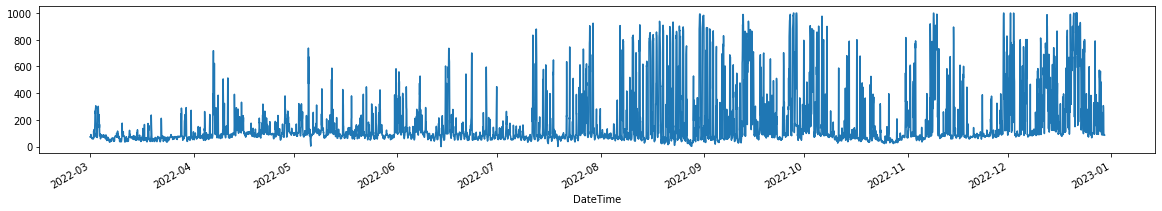

In [14]:
df['Price ($)'].plot(figsize=(20, 3))

<AxesSubplot:title={'center':'AIL Demand'}, xlabel='DateTime', ylabel='AIL Demand (MW)'>

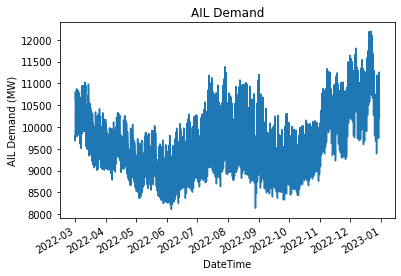

In [15]:
df['AIL Demand (MW)'].plot(ylabel='AIL Demand (MW)', title='AIL Demand')

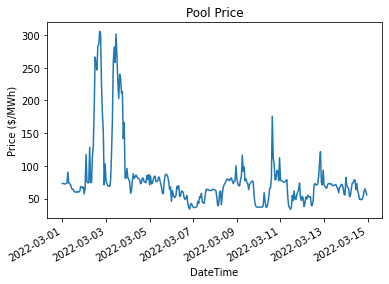

In [20]:
plot = df[df.index < datetime(2022, 3, 15)]['Price ($)'].plot(ylabel='Price ($/MWh)', title='Pool Price')
fig = plot.get_figure()
# fig.savefig('Alberta_moe.pdf')
fig.savefig('Pool_Price_plot.png',dpi=300)

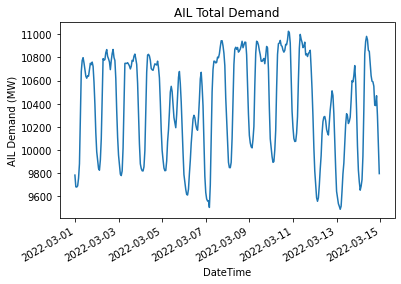

In [25]:
# AIL demand should not be fixed in an hour; it fluctuates minutes by minutes accross an hour.
# A more accurate demand is from the actually dispatched total amount in the merit order.

plot = df[df.index < datetime(2022, 3, 15)]['AIL Demand (MW)'].plot(ylabel='AIL Demand (MW)', title='AIL Total Demand')
fig = plot.get_figure()
# fig.savefig('Alberta_moe.pdf')
fig.savefig('AIL_plot.png',dpi=300)

## Calculate Submit Offer

In [4]:
import pandas as pd
from datetime import datetime
import os

os.chdir('/mnt/bpet-contracts/aeso/')
print(os.getcwd())

/mnt/bpet-contracts/aeso


### Load Original Merit Order

In [11]:
dfmoe = pd.read_csv('MeritOrderSnapshotEnergy_03012022_05012022.csv', parse_dates=['Date'], index_col=0)
dfmoe = dfmoe[(dfmoe['Date'] <= datetime(2022, 3, 14)) & 
              (dfmoe['Available MW'] != 0)].drop(columns=['Import/Export', 'Dispatched', 'Dispatched MW', 'Flexible', 'Effective Date/Time'])
# dfmoe['Price'] = (dfmoe['Price'] * 100).astype('int')
dfmoe.index.name = 'Index'
dfhours = []
for date in dfmoe['Date'].unique():
  for hour in range(1, 25):
    dfh = dfmoe[(dfmoe['Date'] == date) & (dfmoe['HE'] == hour)].iloc[::-1]
    dfhours.append(dfh)
dfmoe = pd.concat(dfhours).drop(labels=['From', 'To', 'Size'], axis=1)
dfmoe

,Date,HE,Asset Id,Block Number,Price,Available MW,Offer Control
Index,,,,,,,
223,2022-03-01,1,GN3,0,0.00,466,Capital Power GP Holdings Inc.
222,2022-03-01,1,SCR6,0,0.00,465,Suncor Energy Inc.
221,2022-03-01,1,KH3,0,0.00,450,TransAlta Energy Marketing Corp.
220,2022-03-01,1,EGC1,0,0.00,390,Capital Power GP Holdings Inc.; ENMAX Energy C...
219,2022-03-01,1,GN2,0,0.00,300,Capital Power GP Holdings Inc.
...,...,...,...,...,...,...,...
5181,2022-03-14,24,BFD1,1,999.99,3,Horseshoe Power GP Ltd.
5180,2022-03-14,24,ME03,1,999.99,3,URICA Asset Optimization Ltd.
5179,2022-03-14,24,BHL1,1,999.99,2,URICA Asset Optimization Ltd.


### Calculate submitOffers

In [12]:

# pd.set_option('display.max_rows', 300)
dfs = []
df = dfmoe.copy()
df = df.set_index(keys=['Date', 'HE'])
indics = df.index.unique()
for i in range(len(indics)):
    df1 = df[df.index == indics[i]]
    # print(indics[i], df1.shape)
    if i == 0:
        dfall = df1.assign(_merge='left_only', Date=indics[i][0], HE=indics[i][1])
    else:
        df2 = df[df.index == indics[i-1]]
        dfall = df1.merge(df2.drop_duplicates(), 
                     on=['Asset Id', 'Block Number', 'Price',
                         'Available MW', 'Offer Control'], 
                     how='outer', 
                     indicator=True)
        dfall = dfall[dfall['_merge'] != 'both']
        # keep only the update offer and offer need to be cleared
        dfall = dfall.drop_duplicates(subset=['Asset Id', 'Block Number'], keep="first")
        dfall = dfall.assign(Date=indics[i][0], HE=indics[i][1])
    dfs.append(dfall.sort_values(by=['Asset Id']))
df_offers = pd.concat(dfs)
cols = df_offers.columns.tolist()
cols = cols[-3:]+cols[:-3]
df_offers.reset_index(inplace=True)
df_offers.index.name = 'Index'
df_offers = df_offers[cols]
df_offers

,_merge,Date,HE,Asset Id,Block Number,Price,Available MW,Offer Control
Index,,,,,,,,
0,left_only,2022-03-01,1,AFG1,0,0.00,18,Alberta Pacific Forest Industries
1,left_only,2022-03-01,1,AFG1,1,80.00,6,Alberta Pacific Forest Industries
2,left_only,2022-03-01,1,AFG1,2,200.00,7,Alberta Pacific Forest Industries
3,left_only,2022-03-01,1,AFG1,3,500.00,5,Alberta Pacific Forest Industries
4,left_only,2022-03-01,1,AFG1,4,999.00,7,Alberta Pacific Forest Industries
...,...,...,...,...,...,...,...,...
11343,left_only,2022-03-14,24,SH2,2,73.36,30,TransAlta Cogeneration LP
11344,left_only,2022-03-14,24,SH2,6,79.97,47,Alberta Power (2000) Ltd.
11345,left_only,2022-03-14,24,SH2,1,72.99,40,TransAlta Cogeneration LP


In [13]:
df_offers.to_csv('SubmitOffer_20220301_20220314.csv')

### Verify Results

In [10]:
df_offers = pd.read_csv('SubmitOffer_20220301_20220314.csv', parse_dates=['Date'], index_col=0)
df = df_offers.copy().drop(labels=['_merge'], axis=1)
df = df.set_index(keys=['Date', 'HE'])
indics = df.index.unique()
# verify two continuous hours' offers
df1 = df[df.index == (datetime(2022,3,3), 10)]
df2 = df[df.index == (datetime(2022,3,3), 11)]
dfall = df2.merge(df1.drop_duplicates(), 
          on=['Asset Id', 'Block Number', 'Price', 'Available MW', 'Offer Control'], 
          how='outer', 
          indicator=True)
dfleft = df2.merge(df1.drop_duplicates(), 
          on=['Asset Id', 'Block Number'], 
          how='outer', 
          indicator=True)
dfnew = dfleft[dfleft['_merge'] == 'left_only']

print('{} df1 {} => {} df2 {}'.format(df1.index.values[0], df1.shape, df2.index.values[0], df2.shape))

print('Unchanged {} (no need to submit)'.format(dfall[dfall['_merge'] == 'both'].shape[0]))
df_merged = dfall[dfall['_merge'] != 'both'].drop_duplicates(subset=['Asset Id', 'Block Number'], keep="first")
print('Changed {} (need to submit)'.format(df_merged.shape[0]))

print('Deleted {}'.format(df_merged[df_merged['_merge'] == 'right_only'].shape[0]))
print('New Added {}'.format(dfnew.shape[0]))
print('Updated {}'.format(dfleft[dfleft['_merge'] == 'both'].shape[0] - 
                          dfall[dfall['_merge'] == 'both'].shape[0]))

(Timestamp('2022-03-03 00:00:00'), 10) df1 (26, 5) => (Timestamp('2022-03-03 00:00:00'), 11) df2 (36, 5)
Unchanged 0 (no need to submit)
Changed 48 (need to submit)
Deleted 12
New Added 22
Updated 14


## Calculate Submit Bid

In [50]:
dfpp = df[df['Date'] < datetime(2022, 3, 15)]
dfpp

,,Date (HE),Price ($),30Ravg ($),AIL Demand (MW),Date,HE
,DateTime,,,,,,
0,2022-03-01 00:00:00,03/01/2022 01,73.07,101.79,9784.0,2022-03-01,01
1,2022-03-01 01:00:00,03/01/2022 02,72.85,101.82,9683.0,2022-03-01,02
2,2022-03-01 02:00:00,03/01/2022 03,72.56,101.86,9681.0,2022-03-01,03
3,2022-03-01 03:00:00,03/01/2022 04,72.32,101.89,9691.0,2022-03-01,04
4,2022-03-01 04:00:00,03/01/2022 05,72.80,101.93,9757.0,2022-03-01,05
...,...,...,...,...,...,...,...
330,2022-03-14 19:00:00,03/14/2022 20,52.97,104.47,10384.0,2022-03-14,20
331,2022-03-14 20:00:00,03/14/2022 21,61.19,104.51,10469.0,2022-03-14,21
332,2022-03-14 21:00:00,03/14/2022 22,64.88,104.54,10294.0,2022-03-14,22


In [37]:
dfsmp = pd.read_csv('HistoricalSystemMarginalPrice_09012021_08312022.csv', index_col=0)
dfsmp[['Date', 'HE']] = dfsmp['Date (HE)'].str.split(' ', expand=True)
dfsmp['Date'] = pd.to_datetime(dfsmp['Date'])
dfsmp = dfsmp[(dfsmp['Date'] >= datetime(2022, 3, 1)) & (dfsmp['Date'] < datetime(2022, 3, 15))].sort_values(by=['Date', 'HE', 'Time'])
dfsmp

,Date (HE),Time,Price ($),Date,HE
418,03/01/2022 01,24:00,72.74,2022-03-01,01
417,03/01/2022 01,24:05,73.58,2022-03-01,01
416,03/01/2022 01,24:28,73.23,2022-03-01,01
415,03/01/2022 01,24:29,72.74,2022-03-01,01
414,03/01/2022 02,01:00,72.85,2022-03-01,02
...,...,...,...,...,...
2112,03/14/2022 23,22:10,59.95,2022-03-14,23
2111,03/14/2022 24,23:00,59.95,2022-03-14,24
2110,03/14/2022 24,23:13,55.70,2022-03-14,24
2109,03/14/2022 24,23:20,54.62,2022-03-14,24


In [39]:
dfsmp_hour = dfsmp[(dfsmp['Date'] == datetime(2022, 3, 1)) & (dfsmp['HE'] == '01')]
dfsmp_hour

,Date (HE),Time,Price ($),Date,HE
418,03/01/2022 01,24:00,72.74,2022-03-01,01
417,03/01/2022 01,24:05,73.58,2022-03-01,01
416,03/01/2022 01,24:28,73.23,2022-03-01,01
415,03/01/2022 01,24:29,72.74,2022-03-01,01


In [40]:
dfmoe_hour = dfmoe[(dfmoe['Date'] == datetime(2022, 3, 1)) & (dfmoe['HE'] == 1)]
dfmoe_hour

,Date,HE,Import/Export,Asset Id,Block Number,Price,From,To,Size,Available MW,Dispatched,Dispatched MW,Flexible,Offer Control,Effective Date/Time
0,2022-03-01,1,NaN,ME04,1,999.99,4,6,2,2,N,0,Y,URICA Asset Optimization Ltd.,03/01/2022 00:57
1,2022-03-01,1,NaN,BHL1,1,999.99,3,5,2,2,N,0,Y,URICA Asset Optimization Ltd.,03/01/2022 00:57
2,2022-03-01,1,NaN,COD1,1,999.99,3,5,2,2,N,0,Y,Signalta Resources Limited,03/01/2022 00:57
3,2022-03-01,1,NaN,ALP1,1,999.99,4,7,3,3,N,0,Y,Campus Energy Partners LP,03/01/2022 00:57
4,2022-03-01,1,NaN,BFD1,1,999.99,3,6,3,3,N,0,N,Horseshoe Power GP Ltd.,03/01/2022 00:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,2022-03-01,1,NaN,GN2,0,0.00,0,300,300,300,Y,300,N,Capital Power GP Holdings Inc.,03/01/2022 00:57
220,2022-03-01,1,NaN,EGC1,0,0.00,0,390,390,390,Y,390,N,Capital Power GP Holdings Inc.; ENMAX Energy C...,03/01/2022 00:57
221,2022-03-01,1,NaN,KH3,0,0.00,0,463,463,450,Y,450,Y,TransAlta Energy Marketing Corp.,03/01/2022 00:57
222,2022-03-01,1,NaN,SCR6,0,0.00,0,465,465,465,Y,465,Y,Suncor Energy Inc.,03/01/2022 00:57


In [51]:
dispatch = []
for  _, row in dfpp.iterrows():
  dfsmp_hour = dfsmp[(dfsmp['Date'] == row['Date']) & (dfsmp['HE'] == row['HE'])]
  dfmoe_hour = dfmoe[(dfmoe['Date'] == row['Date']) & (dfmoe['HE'] == int(row['HE']))]
  for price in dfsmp_hour['Price ($)'].values:
    dfmoe_minute = dfmoe_hour[dfmoe_hour['Price'] <= price]
    dispatch.append(dfmoe_minute['Size'].sum())
dfsmp['Dispatched'] = dispatch
dfsmp

,Date (HE),Time,Price ($),Date,HE,Dispatched
418,03/01/2022 01,24:00,72.74,2022-03-01,01,11045
417,03/01/2022 01,24:05,73.58,2022-03-01,01,11164
416,03/01/2022 01,24:28,73.23,2022-03-01,01,11115
415,03/01/2022 01,24:29,72.74,2022-03-01,01,11045
414,03/01/2022 02,01:00,72.85,2022-03-01,02,11054
...,...,...,...,...,...,...
2112,03/14/2022 23,22:10,59.95,2022-03-14,23,9845
2111,03/14/2022 24,23:00,59.95,2022-03-14,24,9767
2110,03/14/2022 24,23:13,55.70,2022-03-14,24,9704
2109,03/14/2022 24,23:20,54.62,2022-03-14,24,9607


In [60]:
dfsmp = pd.read_csv('SubmitBid_20220301_20220314.csv', usecols=[1,2,3,4,5,6])
dfsmp.index.name = "Index"
dfsmp

,Date (HE),Time,Price ($),Date,HE,Dispatched
Index,,,,,,
0,03/01/2022 01,24:00,72.74,2022-03-01,1,11045
1,03/01/2022 01,24:05,73.58,2022-03-01,1,11164
2,03/01/2022 01,24:28,73.23,2022-03-01,1,11115
3,03/01/2022 01,24:29,72.74,2022-03-01,1,11045
4,03/01/2022 02,01:00,72.85,2022-03-01,2,11054
...,...,...,...,...,...,...
1252,03/14/2022 23,22:10,59.95,2022-03-14,23,9845
1253,03/14/2022 24,23:00,59.95,2022-03-14,24,9767
1254,03/14/2022 24,23:13,55.70,2022-03-14,24,9704


In [61]:
dfsmp.to_csv('SubmitBid_20220301_20220314.csv')

## Calculate Registry

In [32]:
dfmoe2 = dfmoe[dfmoe['Date'] <= datetime(2022, 3, 14)][['Date', 'HE', 'Asset Id', 'Block Number', 'Price', 'From', 'To', 'Available MW','Offer Control']]
dfmoe2

,Date,HE,Asset Id,Block Number,Price,From,To,Available MW,Offer Control
0,2022-03-01,1,ME04,1,999.99,4,6,2,URICA Asset Optimization Ltd.
1,2022-03-01,1,BHL1,1,999.99,3,5,2,URICA Asset Optimization Ltd.
2,2022-03-01,1,COD1,1,999.99,3,5,2,Signalta Resources Limited
3,2022-03-01,1,ALP1,1,999.99,4,7,3,Campus Energy Partners LP
4,2022-03-01,1,BFD1,1,999.99,3,6,3,Horseshoe Power GP Ltd.
...,...,...,...,...,...,...,...,...,...
5396,2022-03-14,24,BSR1,0,0.00,0,300,300,EDF Renewables Development Inc.
5397,2022-03-14,24,PWBC,0,0.00,0,326,326,Powerex Corp.
5398,2022-03-14,24,EGC1,0,0.00,0,390,390,Capital Power GP Holdings Inc.; ENMAX Energy C...
5399,2022-03-14,24,SCR6,0,0.00,0,455,455,Suncor Energy Inc.


In [35]:
assets = dfmoe2['Asset Id'].unique()
blockNums, capacities, offerControls = [], [], []
for asset in assets:
  dfx = dfmoe2[dfmoe2['Asset Id'] == asset]
  blockNums.append(max(dfx['Block Number'].values) + 1)
  capacities.append(max(dfx['To'].values))
  offerControls.append(dfx['Offer Control'].values[0])
dfregistry = pd.DataFrame(data = {'AssetId': assets, 'BlockNumber': blockNums, 'Capacity': capacities, 'OfferControl': offerControls})
dfregistry.index.name = 'Index'
dfregistry

,AssetId,BlockNumber,Capacity,OfferControl
0,ME04,2,6,URICA Asset Optimization Ltd.
1,BHL1,2,5,URICA Asset Optimization Ltd.
2,COD1,2,5,Signalta Resources Limited
3,ALP1,2,7,Campus Energy Partners LP
4,BFD1,2,6,Horseshoe Power GP Ltd.
...,...,...,...,...
137,DYBC,1,48,Dynasty Power Inc.
138,TAY1,7,14,TransAlta Corporation
139,EMXB,1,50,Capital Power GP Holdings Inc.
140,BR4,4,155,Heartland Generation Ltd.


In [46]:
dfregistry.to_csv('Registry_20220301_20220314.csv')

In [76]:
assets

array(['ME04', 'BHL1', 'COD1', 'ALP1', 'BFD1', 'ME03', 'ME02', 'WCD1',
       'ALP2', 'SDH1', 'GEN5', 'SCR6', 'BIG', 'BOW1', 'SUM1', 'CCMH',
       'WWD1', 'AFG1', 'CRS3', 'APS1', 'CRS2', 'KH2', 'CRS1', 'ENC1',
       'ENC2', 'ENC3', 'BRA', 'EC01', 'CAL1', 'ALS1', 'VVW1', 'SET1',
       'DOWG', 'VVW2', 'PH1', 'EGC1', 'CMH1', 'DAI1', 'NPP1', 'GEN6',
       'SH2', 'EAGL', 'SH1', 'RB5', 'ANC1', 'HRT1', 'JOF1', 'HRM', 'FH1',
       'GN1', 'TC01', 'GN2', 'MKR1', 'DRW1', 'OMRH', 'DKSN', 'MUL1',
       'GPEC', 'BRD1', 'UOC1', 'NRG3', 'BUL1', 'TLM2', 'BSC1', 'BUL2',
       'STR1', 'WEF1', 'INF1', 'ERV2', 'ERV1', 'CRE3', 'BUR1', 'VXH1',
       'JER1', 'HYS1', 'SUF1', 'HUL1', 'SCR2', 'SCR3', 'BCR2', 'CRR2',
       'HMT1', 'CR1', 'RTL1', 'SCR1', 'SCL1', 'WEY1', 'OWF1', 'RL1',
       'ESBC', 'SPSK', 'IEW1', 'CLR1', 'BCRK', 'KHW1', 'GWW1', 'IEW2',
       'BTR1', 'ARD1', 'AKE1', 'FNG1', 'TC02', 'CLR2', 'CRR1', 'TAB1',
       'EC04', 'NEP1', 'PR1', 'SCR4', 'CL01', 'RIV1', 'WRW1', 'MEG1',
       'MOMT

In [78]:
len(assets)

142

In [77]:
assets2 = dfmoe['Asset Id'].unique()
assets2

array(['GN3', 'SCR6', 'KH3', 'EGC1', 'GN2', 'BSR1', 'PWBC', 'SCR5',
       'WHT1', 'MKRC', 'GN1', 'NX02', 'MKR1', 'IOR2', 'FH1', 'IOR1',
       'WHT2', 'HAL1', 'APS1', 'CMH1', 'MOMT', 'DOWG', 'JOF1', 'MEG1',
       'SH1', 'SH2', 'CAL1', 'WRW1', 'RIV1', 'CL01', 'SCR4', 'PR1',
       'NEP1', 'EC04', 'TAB1', 'CRR1', 'CLR2', 'TC02', 'HRM', 'FNG1',
       'AKE1', 'ARD1', 'BTR1', 'IEW2', 'GWW1', 'KH2', 'TC01', 'KHW1',
       'BCRK', 'CLR1', 'IEW1', 'NPP1', 'SPSK', 'ESBC', 'RL1', 'OWF1',
       'BIG', 'WEY1', 'ALS1', 'SCL1', 'SCR1', 'RTL1', 'EC01', 'CR1',
       'HMT1', 'CCMH', 'CRR2', 'HRT1', 'BCR2', 'SCR3', 'SCR2', 'HUL1',
       'SUF1', 'HYS1', 'JER1', 'VXH1', 'BOW1', 'BUR1', 'CRE3', 'INF1',
       'WEF1', 'AFG1', 'STR1', 'EAGL', 'WCD1', 'BUL2', 'BSC1', 'TLM2',
       'BUL1', 'BRA', 'NRG3', 'UOC1', 'BRD1', 'GEN6', 'DAI1', 'GPEC',
       'SDH1', 'ALP2', 'GEN5', 'MUL1', 'WWD1', 'ALP1', 'ME02', 'ME04',
       'DKSN', 'OMRH', 'BHL1', 'BFD1', 'DRW1', 'COD1', 'ANC1', 'RB5',
       'PH1', 'VVW2',

In [79]:
len(assets2)

141